# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 12:19:18.481795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 12:19:18.983295: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 12:19:18.983347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30945 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [95]:
config = json.load(open("./configs/mnn_em_w2v_amazon.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=False,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
# data = data.sample(10000)
data

Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,back coverb0853wv73kamazonfresh decaf colombia...,67/67d14e87.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07tf19j7hamazon brand - solimo de...,db/db16adc6.jpg,CELLULAR_PHONE_CASE,1
2,sandal for women stylishb07xrzcjvfflavia women...,ba/ba367541.jpg,SHOES,1
3,mobile coverb08547nsvqamazon brand - solimo de...,f4/f4f744f8.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb07tg4vrmxamazon brand - solimo de...,4a/4a642ac4.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168171,mobile coverb07t36tlkwamazon brand - solimo de...,e3/e38eebd2.jpg,CELLULAR_PHONE_CASE,1
168172,mobile coverb07t9tnbj4amazon brand - solimo de...,22/22fe6185.jpg,CELLULAR_PHONE_CASE,1
168173,shoesb076ynv36kamazon brand - solimo magnetic ...,70/700f407c.jpg,CELLULAR_PHONE_CASE,0
168174,"ankerb07wxb34s8concrete swatch, ravenna home",54/54c029d5.jpg,CELLULAR_PHONE_CASE,0


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing (explorative purposes)

The following parts are largely based of https://www.tensorflow.org/tutorials/text/word2vec

![word2vec_negative_sampling](https://tensorflow.org/tutorials/text/images/word2vec_negative_sampling.png)

## Skip-gram sampling table 

A large dataset means larger vocabulary with higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as `the`, `is`, `on`) don't add much useful information  for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality. 

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to  generate a word-frequency rank based probabilistic sampling table and pass it to the `skipgrams` function. Inspect the sampling probabilities for a `vocab_size` of 10.

In [11]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


`sampling_table[i]` denotes the probability of sampling the i-th most common word in a dataset. The function assumes a [Zipf's distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) of the word frequencies for sampling.

Key point: The `tf.random.log_uniform_candidate_sampler` already assumes that the vocabulary frequency follows a log-uniform (Zipf's) distribution. Using these distribution weighted sampling also helps approximate the Noise Contrastive Estimation (NCE) loss with simpler loss functions for training a negative sampling objective.

## Generate training data

Compile all the steps described above into a function that can be called on a list of vectorized sentences obtained from any text dataset. Notice that the sampling table is built before sampling skip-gram word pairs. You will use this function in the later sections.

In [12]:
import string
import re
from tqdm import tqdm
from tensorflow.keras.layers import TextVectorization

In [13]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets_batch, contexts_batch, labels_batch = [], [], []
    # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm(sequences):
    
        targets, contexts, labels = [], [], []
        
        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size=vocab_size,
        sampling_table=sampling_table,
        window_size=window_size,
        negative_samples=0)
        
        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling")
            
            # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
            
            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
        # Append each element from the training example to global lists.
        targets_batch.append(targets)
        contexts_batch.append(contexts)
        labels_batch.append(labels)
    
    return targets_batch, contexts_batch, labels_batch

## Vectorize sentences from the corpus

You can use the `TextVectorization` layer to vectorize sentences from the corpus. Learn more about using this layer in this [Text classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial. Notice from the first few sentences above that the text needs to be in one case and punctuation needs to be removed. To do this, define a `custom_standardization function` that can be used in the TextVectorization layer.

In [14]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  return tf.strings.regex_replace(input_data,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
sequence_length = 50

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    output_mode='int',
    output_sequence_length=sequence_length)

Call `TextVectorization.adapt` on the text dataset to create vocabulary.

In [15]:
vectorize_layer.adapt(text)

Once the state of the layer has been adapted to represent the text corpus, the vocabulary can be accessed with `TextVectorization.get_vocabulary`. This function returns a list of all vocabulary tokens sorted (descending) by their frequency.

In [16]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'mobile', 'back', 'brand', 'for', 'solimo', 'cover', 'case', 'designer', 'printed', 'hard', '3d', 'soft', 'uv', 'samsung', 'galaxy', 'pattern', 'plus', 'vivo']


The `vectorize_layer` can now be used to generate vectors for each element in `text`.

In [17]:
text = vectorize_layer(text).numpy()
text.shape

(168176, 50)

In [18]:
for t in text[:3]:
  print(f"{t} => {[inverse_vocab[i] for i in t]}")

[    3 91913  2587  3835   639   166   452  1080   109   144     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] => ['back', 'coverb0853wv73kamazonfresh', 'decaf', 'colombia', 'ground', 'coffee', 'medium', 'roast', '12', 'ounce', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[    2 31361     4     6     9    23   103    12    10    11     3     8
     2     7     5    32    34    46    25    67    60     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] => ['mobile', 'coverb07tf19j7hamazon', 'brand', 'solimo', 'designer', 'multicolor', 'sparkle', '3d', 'printed',

## Generate training examples from sequences

`text` is now a list of int encoded sentences. Just call the `generate_training_data` function defined earlier to generate training examples for the word2vec model. To recap, the function iterates over each word from each sequence to collect positive and negative context words. Length of target, contexts and labels should be the same, representing the total number of training examples.

In [19]:
len(inverse_vocab)

164235

In [20]:
targets, contexts, labels = generate_training_data(
    sequences=text[:16],
    window_size=2,
    num_ns=4,
    vocab_size=len(inverse_vocab),
    seed=42)

len(targets)

# print('\n')
# print(f"targets.shape: {targets.shape}")
# print(f"contexts.shape: {contexts.shape}")
# print(f"labels.shape: {labels.shape}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 425.87it/s]


16

In [21]:
from tensorflow.keras.layers import Embedding


class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_ns):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)
        
    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        # if len(target.shape) == 2:
        #   target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        
        # context_emb: (batch, context, embed)
        dots = tf.einsum('abe,abce->abc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

targets = pad_sequences(targets, maxlen=sequence_length, padding='post')
contexts = pad_sequences(contexts, maxlen=sequence_length, padding='post')

targets.shape, contexts.shape

((16, 50), (16, 50, 5))

In [23]:
embedding_dim = 128
word2vec = Word2Vec(len(inverse_vocab), embedding_dim, num_ns=4)

In [24]:
word2vec((targets, contexts)).shape

TensorShape([16, 50, 5])

In [25]:
text = generate_training_data(
    sequences=text,
    window_size=2,
    num_ns=4,
    vocab_size=len(inverse_vocab),
    seed=42)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 168176/168176 [06:58<00:00, 401.91it/s]


In [26]:
targets, contexts, _ = text

targets = pad_sequences(targets, maxlen=sequence_length, padding='post')
contexts = pad_sequences(contexts, maxlen=sequence_length, padding='post')

targets.shape, contexts.shape

((168176, 50), (168176, 50, 5))

# Image processing

In [27]:
from utils.img_processing import load_img_model, create_embeddings_from

In [28]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [29]:
%%time
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=4096)

Found 168176 validated image filenames.


2023-06-14 12:27:39.111180: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-06-14 12:27:40.347171: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


CPU times: user 4min 25s, sys: 2min 45s, total: 7min 11s
Wall time: 10min 12s


In [30]:
img.shape

(168176, 576)

# Save embeddings

In [31]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/w2v/{img_model.name}")

In [32]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/targets.npy", targets)
np.save(f"{save_path}/contexts.npy", contexts)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [96]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,back coverb0853wv73kamazonfresh decaf colombia...,67/67d14e87.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07tf19j7hamazon brand - solimo de...,db/db16adc6.jpg,CELLULAR_PHONE_CASE,1
2,sandal for women stylishb07xrzcjvfflavia women...,ba/ba367541.jpg,SHOES,1
3,mobile coverb08547nsvqamazon brand - solimo de...,f4/f4f744f8.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb07tg4vrmxamazon brand - solimo de...,4a/4a642ac4.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168171,mobile coverb07t36tlkwamazon brand - solimo de...,e3/e38eebd2.jpg,CELLULAR_PHONE_CASE,1
168172,mobile coverb07t9tnbj4amazon brand - solimo de...,22/22fe6185.jpg,CELLULAR_PHONE_CASE,1
168173,shoesb076ynv36kamazon brand - solimo magnetic ...,70/700f407c.jpg,CELLULAR_PHONE_CASE,0
168174,"ankerb07wxb34s8concrete swatch, ravenna home",54/54c029d5.jpg,CELLULAR_PHONE_CASE,0


In [97]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168176, 576)

In [98]:
targets = np.load(f"{save_path}/targets.npy", allow_pickle=True)
targets.shape

(168176, 50)

In [99]:
contexts = np.load(f"{save_path}/contexts.npy", allow_pickle=True)
contexts.shape

(168176, 50, 5)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [100]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [101]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

Because  `contexts` has three dimensions `(batch, context, embed)`, TF may not reliably split the data during `model.fit()`. Therefore we manually split into `train` and `val`.

In [104]:
train, val, labels_train, labels_val = train_test_split(
    train,
    labels_train,
    stratify=train["product_type"],
    test_size=config["model"]["training"]["validation_split"],
    random_state=42)

In [105]:
img_train = img[train.index]
img_val = img[val.index]
img_test = img[test.index]

targets_train = targets[train.index, :]
targets_val = targets[val.index, :]
targets_test = targets[test.index, :]

contexts_train = contexts[train.index, :, :]
contexts_val = contexts[val.index, :, :]
contexts_test = contexts[test.index, :, :]

# Save Char CNN config

Not needed, as we use GloVe for text embeddings instead

In [106]:
# from models.char_cnn_zhang import CharCNNZhang

In [107]:
# char_cnn_config = {
#     "input_size": config["data"]["input_size"],
#     "embedding_size": len(tk.word_index),
#     "conv_layers": config["char_cnn_zhang"]["conv_layers"],
#     "fc_layers": config["char_cnn_zhang"]["fc_layers"],
#     "output_size": config["char_cnn_zhang"]["output_size"],
#     "embedding_weights": weights
# }

In [108]:
# char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [109]:
# from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [110]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity

class MNNEMWord2Vec(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        targets = Input(
            shape=(sequence_length), dtype=tf.int32, name="Targets_Input")

        # Input Layer
        contexts = Input(
            shape=(sequence_length, 5), dtype=tf.int32, name="Contexts_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, targets, contexts])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, targets, contexts],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Input Layer
        targets = Input(
            shape=(sequence_length), dtype=tf.int32, name="Targets_Input_Head_Outer")

        # Input Layer
        contexts = Input(
            shape=(sequence_length, 5), dtype=tf.int32, name="Contexts_Input_Head_Outer")

        word2vec_model = Word2Vec(len(inverse_vocab), embedding_dim, num_ns=4)

        x = word2vec_model((targets, contexts))

        x = Flatten()(x)

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, targets, contexts],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

In [111]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [112]:
mnn_em = MNNEMWord2Vec(head_config=head_config,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [113]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Targets_Input (InputLayer)     [(None, 50)]         0           []                               
                                                                                                  
 Contexts_Input (InputLayer)    [(None, 50, 5)]      0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          43945728    ['Image_Input[0][0]',            
                                                                  'Targets_Input[0][0]',     

In [114]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [115]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[3].layers[4],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [116]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [117]:
from utils.metrics import create_callbacks

In [118]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [119]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [120]:
history = mnn_em.model.fit(
    x=[img_train, targets_train, contexts_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_data=([img_val, targets_val, contexts_val], labels_val),
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8510/8513 [============================>.] - ETA: 0s - loss: 4.3361 - recall: 0.7334 - precision: 0.6048 - binary_accuracy: 0.6117 - cosine_similarity: 0.5207

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 87s 10ms/step - loss: 4.3353 - recall: 0.7334 - precision: 0.6048 - binary_accuracy: 0.6117 - cosine_similarity: 0.5206 - val_loss: 1.3591 - val_recall: 0.7539 - val_precision: 0.6363 - val_binary_accuracy: 0.6511 - val_cosine_similarity: 0.5153
Epoch 2/10
8513/8513 [==============================] - ETA: 0s - loss: 1.0721 - recall: 0.7883 - precision: 0.6410 - binary_accuracy: 0.6599 - cosine_similarity: 0.5206

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 86s 10ms/step - loss: 1.0721 - recall: 0.7883 - precision: 0.6410 - binary_accuracy: 0.6599 - cosine_similarity: 0.5206 - val_loss: 0.9078 - val_recall: 0.7813 - val_precision: 0.6397 - val_binary_accuracy: 0.6605 - val_cosine_similarity: 0.5153
Epoch 3/10
8510/8513 [============================>.] - ETA: 0s - loss: 0.8068 - recall: 0.8080 - precision: 0.6636 - binary_accuracy: 0.6868 - cosine_similarity: 0.5207

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 86s 10ms/step - loss: 0.8068 - recall: 0.8080 - precision: 0.6636 - binary_accuracy: 0.6868 - cosine_similarity: 0.5206 - val_loss: 0.7856 - val_recall: 0.7609 - val_precision: 0.6408 - val_binary_accuracy: 0.6569 - val_cosine_similarity: 0.5153
Epoch 4/10
8513/8513 [==============================] - ETA: 0s - loss: 0.6467 - recall: 0.8333 - precision: 0.7156 - binary_accuracy: 0.7408 - cosine_similarity: 0.5206

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_w2v_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 87s 10ms/step - loss: 0.6467 - recall: 0.8333 - precision: 0.7156 - binary_accuracy: 0.7408 - cosine_similarity: 0.5206 - val_loss: 0.7748 - val_recall: 0.7569 - val_precision: 0.6391 - val_binary_accuracy: 0.6544 - val_cosine_similarity: 0.5153
Epoch 5/10
8513/8513 [==============================] - 84s 10ms/step - loss: 0.5119 - recall: 0.8599 - precision: 0.7773 - binary_accuracy: 0.7988 - cosine_similarity: 0.5206 - val_loss: 0.8149 - val_recall: 0.7207 - val_precision: 0.6283 - val_binary_accuracy: 0.6364 - val_cosine_similarity: 0.5153
Epoch 6/10
8513/8513 [==============================] - 84s 10ms/step - loss: 0.4083 - recall: 0.8870 - precision: 0.8270 - binary_accuracy: 0.8446 - cosine_similarity: 0.5206 - val_loss: 0.9259 - val_recall: 0.7080 - val_precision: 0.6196 - val_binary_accuracy: 0.6255 - val_cosine_similarity: 0.5153
Epoch 7/10
8513/8513 [==============================] - 84s 10ms/step - loss: 0.3209 - recall: 0.9152 - p

# Evaluation

## Plot loss and metrics

In [121]:
from utils.metrics import plot_metrics

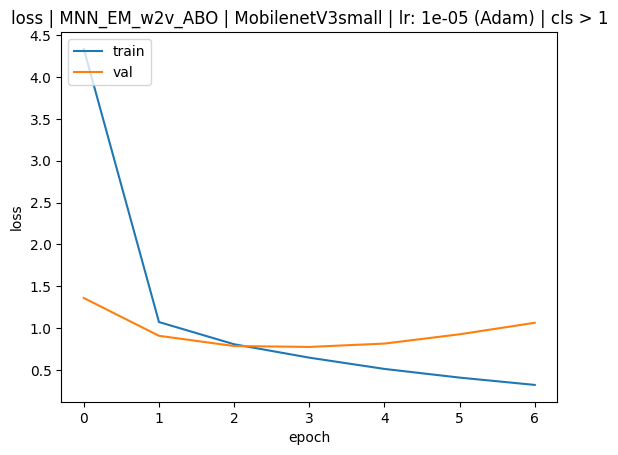

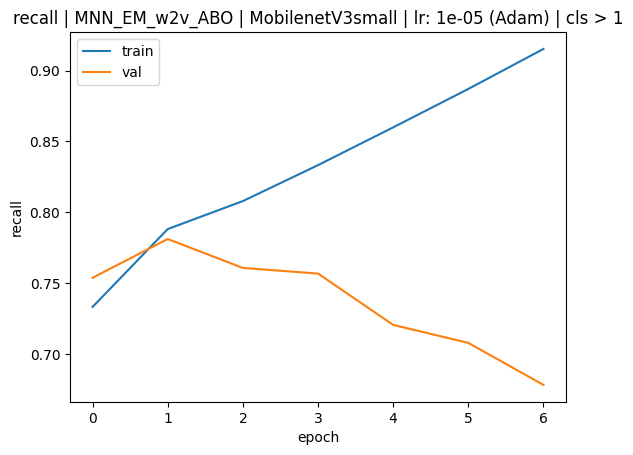

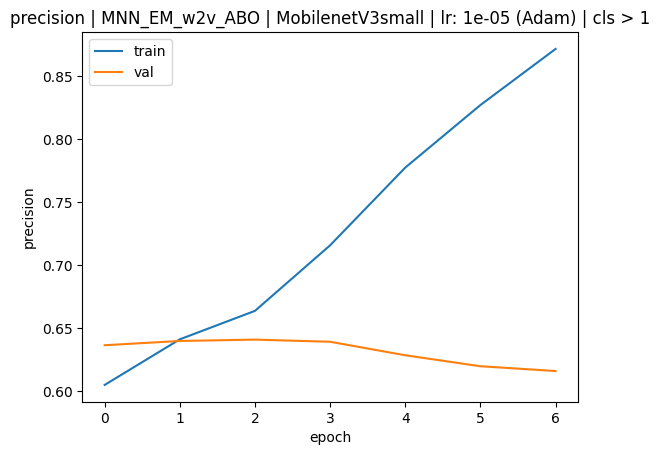

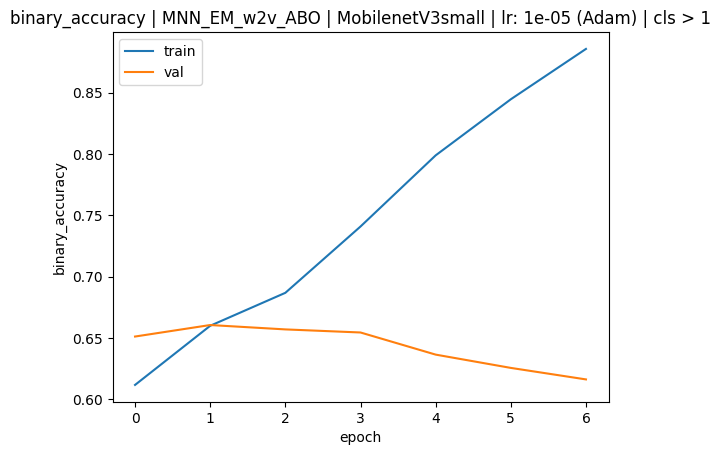

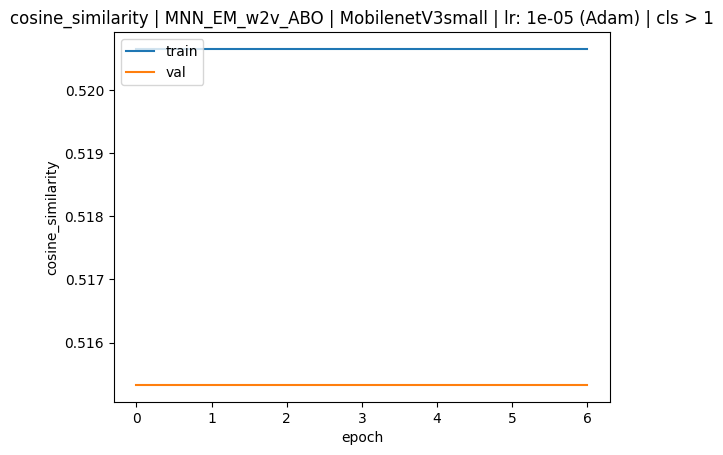

In [122]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [123]:
from utils.metrics import evaluate

In [ ]:
evaluate(mnn_em.model, [img_test, targets_test, contexts_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

 9091/16815 [===============>..............] - ETA: 16s - loss: 1.0754 - recall: 0.6801 - precision: 0.6168 - binary_accuracy: 0.6181 - cosine_similarity: 0.5142